In [ ]:
!pip install -q kaggle
!pip install -qU catboost shap category_encoders tf-models-official
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c santander-customer-transaction-prediction
!unzip train.csv.zip 
!unzip test.csv.zip 
!rm train.csv.zip test.csv.zip
clear_output()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor, Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
import shap
import category_encoders as ce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, VotingClassifier, StackingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, PolynomialFeatures

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as Imbpipe, make_pipeline as pl
from sklearn.pipeline import make_pipeline, Pipeline

from scipy import stats
import statsmodels.stats.power as power

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

from itertools import combinations
from xgboost import XGBClassifier
import xgboost
from lightgbm import LGBMClassifier
import lightgbm

import tensorflow as tf

from tqdm.notebook import tqdm, trange

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
train = pd.read_csv('train.csv', index_col='ID_code')
test = pd.read_csv('test.csv', index_col='ID_code')
TARGET_NAME = 'target'

In [ ]:
train.sample(5)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
train_49673,0,11.5208,0.0345,13.6967,8.7980,11.4984,-14.4183,5.2356,14.6201,1.5236,9.1455,5.9456,3.5337,14.0873,5.0009,9.0715,14.6529,7.2479,-8.5836,10.4604,20.4984,7.5986,7.6692,5.2353,3.3203,13.5917,13.0450,-1.4798,-1.8441,5.9111,3.5479,-12.8192,10.5947,-3.4740,14.3635,11.5727,-1.8772,2.9090,10.2505,10.6378,...,13.9284,5.3969,4.7783,12.0054,-5.0856,22.6595,2.4280,-13.1705,9.1324,6.6124,6.9939,-0.3060,22.2593,-0.6507,24.5936,8.0921,12.1506,12.2034,2.6250,-0.9599,0.3549,10.0505,-9.4061,15.6758,10.9775,-2.5722,5.8963,-7.4840,13.4808,1.6538,-2.5931,6.8155,4.0026,5.7603,16.7222,0.5767,-3.1717,8.9964,19.5975,-16.0881
train_171551,0,10.6327,-3.0837,7.3320,8.9173,9.8485,-10.0986,5.4894,11.2602,-4.5423,9.8008,5.4524,6.9100,14.0182,16.5160,11.6406,14.5897,8.8563,-7.7865,15.8893,-0.1918,6.8843,19.4571,9.2720,2.6856,6.7190,13.5232,0.3841,-0.3236,5.0668,1.7392,-9.4633,11.7253,0.2745,17.8647,11.3387,5.2437,3.6474,8.9879,9.3858,...,27.7609,5.6135,5.5691,19.9314,-0.0440,23.6030,3.4240,-10.7384,5.7603,5.6456,-0.7572,-5.2724,23.3403,8.3239,25.8735,17.1875,-9.5427,15.6595,-2.4391,0.6293,3.8998,9.2978,3.7730,13.0189,-0.8343,-7.9431,7.0021,-3.3181,9.5955,0.9500,7.2326,5.0710,3.4117,4.1256,19.3753,-2.2722,-2.5486,6.3672,16.0392,-0.8213
train_5506,0,13.4346,-4.7138,10.2488,7.2394,11.5154,-10.7816,4.4755,16.3473,4.5706,8.1285,-2.7644,-3.4287,14.0400,12.3976,4.2492,14.5717,10.2619,-9.7160,21.3117,13.8008,11.7685,21.2212,6.7010,3.2142,12.8973,14.1828,-6.0799,-0.2072,4.3603,3.9675,-2.9356,10.7213,0.6995,10.9500,12.3780,10.4824,-0.0414,4.8783,3.4862,...,12.3408,5.4563,5.4260,15.1472,8.4295,16.9865,2.8768,-0.1826,10.7537,5.7620,-1.7159,-9.4156,25.1167,-4.5501,31.4134,10.7159,11.0645,8.8673,2.7656,4.7616,1.4524,12.2323,14.4351,9.0803,7.2682,1.2788,12.7159,3.1815,14.6612,-0.2382,1.5606,14.4879,1.8716,6.0999,21.1498,3.1641,-3.9446,9.4770,17.1406,-18.9208
train_38370,0,4.8650,4.3326,13.9920,6.9034,12.1384,-1.6310,5.2511,14.0651,-4.1907,7.2513,0.7787,1.7712,14.2122,12.7797,6.4129,14.0514,11.6327,-1.8000,15.7764,13.2496,13.9652,32.0569,4.7970,3.4099,10.8712,13.6326,-6.4665,-2.0174,5.1335,6.0730,-8.5769,12.1868,5.1923,16.5180,10.6822,8.0663,4.9223,2.0203,7.5041,...,8.5439,5.4176,3.4623,17.8488,-1.9598,27.6794,3.1724,-8.3333,4.1165,5.9049,-4.7429,1.9022,23.9654,12.5655,29.1972,14.3684,2.1037,13.3272,-18.2538,-1.8824,5.6759,9.5542,10.2843,13.1040,18.8772,-8.4414,6.8891,-20.8613,16.0930,1.0929,-5.9529,5.7586,3.0283,-2.4441,16.7881,-0.2528,-5.1544,8.4277,12.8527,1.1520
train_36930,0,9.8466,-2.0145,10.6657,4.9808,10.0866,-7.7280,4.6048,16.5240,-2.4174,8.7103,-7.3512,-0.4602,14.2672,5.5908,6.1452,14.8170,8.7969,-8.4881,11.3917,17.5183,18.2987,23.7463,6.7272,3.0850,8.7837,13.5678,-0.3993,-3.6143,5.6232,4.9103,-6.3327,13.0012,0.1095,14.4902,12.0678,-2.7829,3.5168,3.0761,14.6576,...,13.3904,5.3606,5.9861,12.5962,-0.6721,16.8965,3.3998,-10.0593,6.0237,5.4878,7.7735,0.5594,32.3851,-5.5665,24.8996,9.1090,-4.8413,9.3031,-6.9354,-1.5422,3.7844,10.8223,11.4703,15.0865,8.8179,-2.9589,12.1023,-19.5603,13.8247,1.5473,-0.5729,9.0527,1.2550,-4.4527,16.0889,0.8156,4.3412,9.0945,13.4120,8.3931


In [ ]:
test.sample(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
test_49673,11.1044,-6.7099,17.8710,3.2243,8.8478,-13.3124,5.7892,12.9625,-0.6813,9.0070,13.5886,-12.5065,14.0553,4.1215,10.1845,14.1874,14.3149,-10.6151,7.3701,11.3901,5.4234,21.2076,8.5908,2.7828,12.1921,13.9060,2.3430,1.4021,5.6045,5.9293,-13.4491,12.4681,3.8327,12.2699,11.5644,12.4283,5.8435,6.7158,9.1686,-1.3110,...,10.1630,5.3300,5.8551,13.3925,-10.9037,16.6126,2.8403,-4.7086,0.2260,5.5038,-6.6663,0.2023,11.0996,4.7772,15.8899,6.9971,-11.0400,9.8729,-22.6348,5.0912,1.1738,13.5646,1.1082,1.6413,14.2367,-0.1334,11.5969,1.7991,21.5119,0.6749,5.9420,5.6437,2.2066,6.2148,21.5757,-3.0771,-4.2946,9.0310,20.9245,3.1500
test_171551,5.7274,-0.4187,12.6714,7.7062,9.8400,8.3206,5.9172,14.9554,-2.4336,6.8754,1.8640,-3.7242,13.9912,1.9003,7.1754,14.6355,8.5084,-1.5631,9.0840,16.0378,12.9023,27.0006,7.6688,2.8290,9.7176,13.7174,-11.8454,-3.1446,5.2714,4.7110,-5.4136,11.4871,-0.6129,14.8527,12.0292,7.6095,3.8212,7.2632,1.4052,1.8013,...,6.0265,5.6463,8.3263,9.5156,-12.2517,24.0197,2.4162,-3.6669,9.2744,4.9534,-5.5592,0.9228,16.6513,5.8137,12.3628,9.2538,3.5388,12.3049,-4.9137,7.9479,6.0942,8.7330,-7.3436,10.2535,21.7819,2.1121,7.7764,4.4707,19.8838,2.3187,2.3589,6.6190,4.6949,0.9724,15.1168,-1.5141,9.8740,8.4839,15.3571,-12.1836
test_5506,12.5517,7.9984,11.1343,7.0043,10.8234,-9.9847,5.8742,19.9514,0.5893,7.5170,10.9213,0.4165,13.7779,3.5719,6.0117,14.6908,10.7506,-20.4492,5.0658,12.0596,11.9119,16.6718,2.4269,2.2722,8.2830,13.8693,-9.1130,0.3956,4.9269,6.8980,-3.6927,10.9610,0.4442,11.2844,11.5566,1.0213,6.2537,10.2331,16.9351,2.9438,...,26.1556,5.5354,5.2283,14.6768,-9.3929,20.5401,2.9398,8.8601,3.0230,5.0394,3.3603,5.6864,27.1400,6.6573,26.3436,8.0778,-3.7618,15.4220,-13.1122,-0.5352,2.3797,9.5883,-3.3356,2.2527,0.3354,4.7441,5.6303,4.5744,22.7515,1.5716,4.9495,7.2834,-0.6708,7.4930,21.1419,0.5040,-1.0404,8.3305,15.0389,7.3967
test_38370,8.7687,2.2315,8.0303,5.8999,9.4847,-1.6425,4.6997,19.7067,-2.2117,7.9740,0.0277,-1.0900,13.9061,10.4633,8.9323,15.1684,8.6853,-13.2725,14.8868,15.7976,18.8470,14.9565,4.4289,3.2387,7.2198,13.8394,-13.8184,0.3423,4.6113,4.5242,-15.8836,12.3708,0.3307,13.0074,11.7705,0.6162,3.4612,3.6997,7.5743,3.8687,...,12.5112,5.3818,4.8400,5.5285,4.6651,25.5525,2.9921,-6.2606,3.2324,6.1386,-6.2802,-4.6884,14.5337,3.5628,26.7253,14.2564,0.3115,14.1273,7.0466,-2.9963,-2.6044,12.3199,-11.0687,14.9457,16.4193,4.6467,9.8337,0.6905,19.4675,0.9724,3.7571,7.7909,2.6351,2.5489,18.8010,0.8993,-1.7393,8.9744,13.6331,3.8630
test_36930,12.8101,2.6991,8.3205,10.1344,11.7683,0.0638,4.4188,15.4821,2.0414,9.4290,2.6056,-7.3534,14.4190,0.2309,11.8466,14.9233,7.0877,-2.1833,23.6974,13.0582,22.4238,20.4688,7.4953,2.1490,12.8639,13.5466,-10.6935,0.3011,6.2210,6.5717,-21.2088,12.8033,1.0907,11.8276,12.4836,0.0040,-0.0087,5.4716,11.6502,-2.1862,...,36.6370,5.4525,3.2894,3.0850,3.0834,18.9294,2.7763,-3.5987,3.2649,5.8588,-5.7801,6.1367,15.3493,-3.7047,24.0291,10.3626,-18.6784,8.2139,-1.3909,5.1264,-9.4887,10.9941,7.9230,5.5280,-5.9675,-10.7055,9.3559,-1.1275,14.6293,-0.0976,13.7312,9.6981,2.4056,4.3533,12.7338,-0.6347,1.1318,7.7132,9.6437,11.8016


In [ ]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [ ]:
def report(y_train, y_train_pred, y_train_probas, y_test, y_test_pred, y_test_probas):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    roc_train, roc_test = roc_auc_score(y_train, y_train_probas), roc_auc_score(y_test, y_test_probas)
    print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def reduce_memory(df, silent=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    if not silent:
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if not silent:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label=True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df

def statistic_output(*columns, df=train, cat=False, target=TARGET_NAME, 
                     alpha=0.05, sample_size=0, silent=True):
    weak_output_columns = []
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.01 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', np.object]).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                if not silent:
                    result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                    print(f'Factor "{column}" has statistical influence on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                if not silent:
                    print(f'Factor "{column}" does not affect target.')
                weak_output_columns.append(column)
        return weak_output_columns
    else:
        for column in columns:
            print(column)
            data.reset_index(inplace=True)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['id', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='id', index=column, columns=target, aggfunc='count')
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    if pvalue >= alpha:  
                        print(f'Categories {a} and {b} can be united.')
                    else:
                        print(f'Categories {a} and {b} have different frequencies with target.')

def correlation(df: pd.DataFrame, target=TARGET_NAME, alpha=0.05, threshold=0.66, 
                method='pearson', silent=True):
    data = df.copy()
    data = data.drop(target, axis=1)
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        if method == 'pearson':
            r, pvalue = stats.pearsonr(data[col1], data[col2])
        elif method == 'kendall':
            r, pvalue = stats.kendalltau(data[col1], data[col2])
        elif method == 'spearman':
            r, pvalue = stats.spearmanr(data[col1], data[col2])                   
        else:
            raise ValueError(f'Method should be "spearman", "kendall" or "pearson", got: {method}')
        if r >= threshold:    
            if pvalue < alpha:
                print(f'Correlation ({method}) between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                if not silent:
                    print(f'Correlation ({method}) between {col1} and {col2} is high but not statisticaly meaningful.')

In [ ]:
# NN preprocessing
train = reduce_memory(train)
test = reduce_memory(test)

In [ ]:
stats_weak_train_columns = statistic_output()  
# features that statisticaly have no influence on target (H0 of equality of sample means is true)
len(stats_weak_train_columns)

In [ ]:
correlation(train, threshold=0.33, method='pearson')
# significant correlations between variables
# no hihg correlations

In [ ]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

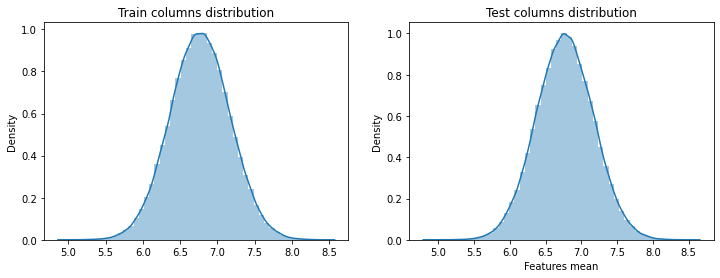

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Train columns distribution')
sns.distplot(train.drop(TARGET_NAME, axis=1).mean(axis=1))
plt.subplot(122)
plt.title('Test columns distribution')
sns.distplot(test.mean(axis=1))
plt.xlabel('Features mean')
plt.show()

In [ ]:
s, pval = stats.ttest_ind(train.drop(TARGET_NAME, axis=1).mean(axis=1), test.mean(axis=1), equal_var=False)
print(f'train and test have same distribution' if pval>0.05 else f'train and test have different distribution')

train and test have same distribution


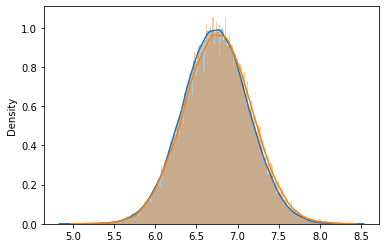

In [ ]:
sns.distplot(train[train[TARGET_NAME] == 0].mean(axis=1), bins=200)
sns.distplot(train[train[TARGET_NAME] == 1].mean(axis=1), bins=200)

In [ ]:
for i in trange(len(train.columns)):
    if i == 199: break
    train[f'var_{i}_diff'] = train[f'var_{i+1}'] - train[f'var_{i}']
train.shape

  0%|          | 0/201 [00:00<?, ?it/s]

(200000, 400)

In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]

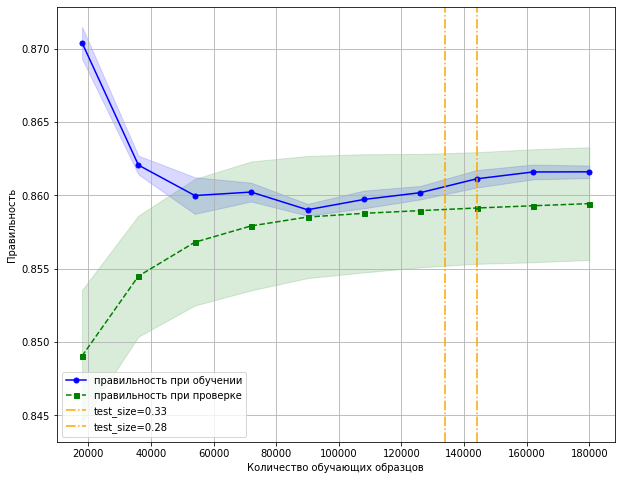

In [ ]:
# split train-valid-test, best split, apply Pipeline transforms
estimator = make_pipeline(MinMaxScaler(), 
                          LogisticRegression(random_state=1, 
                                             solver='lbfgs', 
                                             penalty='l2', 
                                             C=1000.0, 
                                             tol=1e-4, 
                                             max_iter=200, 
                                             class_weight='balanced'))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, 
                                                        X=X, 
                                                        y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=10, 
                                                        scoring='roc_auc', 
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.72, color='orange', linestyle='-.', label='test_size=0.28')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=1)
X_train.shape, X_valid.shape, X_test.shape

((144000, 800), (16000, 800), (40000, 800))

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique(), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5558557863043311, 1: 4.97581202487906}

In [ ]:
# check base
base_estimator = make_pipeline(MinMaxScaler(),
                               LogisticRegression(C=1000.,  
                                                  class_weight=class_weights, 
                                                  max_iter=400, 
                                                  n_jobs=-1))
base_estimator.fit(X_train, y_train)
base_train_preds = base_estimator.predict(X_train)
base_valid_preds = base_estimator.predict(X_valid)
base_test_preds = base_estimator.predict(X_test)
report(y_train, base_train_preds, y_test, base_test_preds)

Train
               precision    recall  f1-score   support

           0      0.970     0.782     0.866    129443
           1      0.286     0.782     0.419     14413

    accuracy                          0.782    143856
   macro avg      0.628     0.782     0.642    143856
weighted avg      0.901     0.782     0.821    143856

Test
               precision    recall  f1-score   support

           0      0.969     0.780     0.864     35956
           1      0.281     0.772     0.412      4004

    accuracy                          0.779     39960
   macro avg      0.625     0.776     0.638     39960
weighted avg      0.900     0.779     0.819     39960

Train ROC_AUC: 0.782, Test ROC_AUC: 0.776
Confusion Matrix 
 col_0       0     1
target             
0       28046  7910
1         912  3092


In [ ]:
# removing possible ouliers (extreme values) by IsolationForest
iso_forest = IsolationForest(n_estimators=100, max_features=0.8, contamination=0.001, n_jobs=-1, random_state=1)
iso_forest.fit(X_train)
for x, tar in [(X_train, y_train), (X_valid, y_valid), (X_test, y_test)]:
    outliers = iso_forest.predict(x)
    outlier_rows_to_drop = x[outliers == -1].index
    x.drop(index=outlier_rows_to_drop, inplace=True)
    tar.drop(index=outlier_rows_to_drop, inplace=True)
print('Train:', X_train.shape, y_train.shape, 'valid:', X_valid.shape, y_valid.shape, 'test', X_test.shape, y_test.shape)

Train: (143856, 200) (143856,) valid: (15980, 200) (15980,) test (39949, 200) (39949,)


In [ ]:
# get mutual info for weak features
def get_mutual_list(X: pd.DataFrame, y:pd.Series, length=15) -> list:
    mi = mutual_info_classif(X, y, random_state=1)
    mi_idx = np.argsort(mi)[::-1]
    return list(X.columns[mi_idx][-length:])

mutual_weak_list = get_mutual_list(X_train, y_train)

In [ ]:
# get statisticaly weak features
X_stat = pd.DataFrame(pd.concat([X_train, y_train], axis=1), columns=train.columns)
statistic_weak_list = statistic_output(df=X_stat)
del X_stat

In [ ]:
# get variance importancies
def get_variance_list(X: pd.DataFrame, length=15) -> list:
    pipe = make_pipeline(MinMaxScaler(), VarianceThreshold())
    X_t = pipe.fit_transform(X)
    indices = np.argsort(pipe[1].variances_)[::-1]
    return list(X.columns[indices]) #[-length:])

var_weak_list = get_variance_list(X_train)

In [ ]:
var_poly_cols = var_weak_list[:30]

In [ ]:
# get catboost list of weak features
def get_cat_weak_list(X:pd.DataFrame, y:pd.Series, length=15) -> list:
    cat_imp = CatBoostClassifier(verbose=False, random_seed=1)
    cat_imp.fit(X_train, y_train)
    importancies = cat_imp.feature_importances_
    imp_indices = np.argsort(importancies)[::-1]
    return list(X.columns[imp_indices][-length:])

cat_weak_list = get_cat_weak_list(X_train, y_train)

In [ ]:
# get weak list by catboost shap-values
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_valid, y_valid)

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1, length=15) -> list:
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=100, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=X_train.shape[1] - length,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=False
    )
    return summary['eliminated_features_names']

shap_weak_list = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


In [ ]:
weak_list = list(set(mutual_weak_list + statistic_weak_list + var_weak_list + cat_weak_list + shap_weak_list))
for_fit_list = np.random.choice(weak_list, replace=False, size=15)
for_fit_list

array(['var_105', 'var_88', 'var_100', 'var_41', 'var_49', 'var_159',
       'var_174', 'var_60', 'var_52', 'var_87', 'var_73', 'var_19',
       'var_74', 'var_176', 'var_79'], dtype='<U7')

In [ ]:
for_fit_list = ['var_40', 'var_112', 'var_3', 'var_92', 'var_87', 'var_156',
                'var_26', 'var_70', 'var_152', 'var_8', 'var_84', 'var_2',
                'var_43', 'var_153', 'var_106']

In [ ]:
import time

class ColumnDropper:

    def __init__(self, columns, scoring='roc_auc_score', test_size=0.2, random_state=1):
        self.scoring = str(scoring)
        self.estimator = None
        self.columns = columns
        self.test_size = test_size
        self.k_features = None
        self.random_state = random_state
        if (self.scoring == 'f1_score') or (self.scoring == 'roc_auc_score'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "f1_score" или "roc_auc_score", дана: {self.scoring}')

    def fit(self, X, y, silent=True):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=self.test_size, 
                                                            stratify=y, 
                                                            shuffle=True,
                                                            random_state=self.random_state)
        
        class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique(), y=y_train)
        class_weights = dict(enumerate(class_weights))
        self.estimator = LGBMClassifier(boosting_type='goss',
                                        max_depth=4,
                                        class_weight=class_weights,
                                        random_state=1)
        
        dim = len(self.columns)
        self.subsets_ = [self.columns]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.columns) 
        self.scores_ = [score]
        self.k_features = X_train.shape[1] - dim

        while dim > 0: 
            scores, subsets = [], []
            start = time.time()
            print(f'Analizing columns {len(self.columns)}, left {dim}:')
            for cols in tqdm(combinations(self.columns, r=dim-1), total=dim):  
                score = self._calc_score(X_train, y_train, X_test, y_test, cols)
                scores.append(score) 
                subsets.append(cols) 
            clear_output(wait=True)
            best = np.argmax(scores) 
            self.columns = subsets[best] 
            self.subsets_.append(self.columns)
            dim -= 1
            self.scores_.append(scores[best]) 
            end = time.time()
            if not silent:
                print(f'Time for one epoch: {end-start} sec, best iteration score: {scores[best]:.2f}')
        return self

    def _calc_score(self, X_train, y_train, X_test, y_test, columns):
        train = X_train.drop(list(columns), axis=1)
        test = X_test.drop(list(columns), axis=1)
        self.estimator.fit(train, y_train)
        y_pred = self.estimator.predict_proba(test)[:,1]
        y_pred = np.argmax(y_pred) if self.scoring == 'roc_auc_score' else y_pred
        score = self.scoring(y_test, y_pred)
        return score

    def transform(self, X):
        columns = self.subsets_[np.argmax(np.array(self.scores_))]
        return X.drop(columns, axis=1)

In [ ]:
selector = ColumnDropper(columns=for_fit_list)
selector.fit(X_train, y_train, silent=False)

In [ ]:
import math

def create_class_weight(labels_dict,mu=0.05):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

class_weights = create_class_weight(y_train.value_counts().to_dict())

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        X = reduce_memory(X)
        return X[self.columns]

class DataFrameR(BaseEstimator, TransformerMixin):
    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert len(self.columns) == X.shape[1], f'Number of columns {len(self.columns)} is not equal to data shape {X.shape[1]}'
        if self.index is not None:
            X_ = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            X_ = pd.DataFrame(X, columns=self.columns)
        return X_

In [ ]:
# pipelines for classifiers, finetune
""" Experimental non-linear relationships
X_train_poly = poly_pipe.fit_transform(X_train, y_train)
X_valid_poly = poly_pipe.transform(X_valid)
X_test_poly = poly_pipe.transform(X_test)
"""

fit_params = {'lgbm__early_stopping_rounds': 15,  
              'lgbm__eval_set': [(X_valid, y_valid)],  
              'lgbm__eval_metric': 'auc',
              'lgbm__verbose': False
}

model_params = {
                'boosting_type':'goss',
                'max_depth': 5,
                'learning_rate':0.06,
                'reg_alpha': 10.5,
                'reg_lambda': 10.5,
                'objective': 'binary',
                'n_estimators': 800,
                'n_jobs': -1,
                #'subsample': 0.6,
                'pos_subsample': 0.9,
                'neg_subsample': 0.1,
                'colsample_bytree': 0.5,
                'num_leaves': 6,
                'is_unbalanced': True,
                'max_bin': 165,
                'min_child_samples': 253,
                'min_child_weight': 0.1, 
                'min_split_gain': 0.18,
                'pos_bagging_fraction': 0.5,
                'random_state': 1
}

base_estimator = Imbpipe(steps=[('selector', ColumnSelector(X_train.columns.to_list())),
                                ('under', RandomUnderSampler(sampling_strategy=0.66, random_state=1)),
                                ('over', RandomOverSampler(sampling_strategy=.8, random_state=1)),
                                ('lgbm', LGBMClassifier(**model_params))] )

base_estimator.fit(X_train, y_train, **fit_params)
base_train_preds = base_estimator.predict(X_train)
base_test_preds = base_estimator.predict(X_test)
base_train_probas = base_estimator.predict_proba(X_train)[:,1]
base_test_probas = base_estimator.predict_proba(X_test)[:,1]
report(y_train, base_train_preds, base_train_probas, y_test, base_test_preds, base_test_probas)

Train
               precision    recall  f1-score   support

           0      0.973     0.858     0.912    129530
           1      0.383     0.786     0.515     14470

    accuracy                          0.851    144000
   macro avg      0.678     0.822     0.714    144000
weighted avg      0.914     0.851     0.872    144000

Test
               precision    recall  f1-score   support

           0      0.967     0.854     0.907     35980
           1      0.361     0.740     0.485      4020

    accuracy                          0.842     40000
   macro avg      0.664     0.797     0.696     40000
weighted avg      0.906     0.842     0.865     40000

Train ROC_AUC: 0.905, Test ROC_AUC: 0.883
Confusion Matrix 
 col_0       0     1
target             
0       30722  5258
1        1047  2973


In [ ]:
y_test.shape, base_test_probas.shape

((40000,), (144000,))

In [ ]:
# skip this experimental step
poly = Pipeline(steps=[('selector', ColumnSelector(var_poly_cols)),
                       ('poly', PolynomialFeatures(degree=2))
                      ])
plain = Pipeline(steps=[('selector2', ColumnSelector(X_train.columns.to_list())),
                       ])

poly_pipe = FeatureUnion(transformer_list=[('polynom', poly),  # ColumnTransformer
                                           ('plain_cols', plain)
                                           ])
X_poly = poly_pipe.fit_transform(X_train, y_train)

In [ ]:
# skip this experimental step
feature_pipe = Pipeline(steps=[('selector', ColumnSelector(X_train.columns.to_list())),
                               ('scaler', MinMaxScaler()),
                               ('bins', KBinsDiscretizer(encode='ordinal', n_bins=500)),
                               ('columner', DataFrameR(columns=X_train.columns.to_list())),
                               #('encoder', ce.m_estimate.MEstimateEncoder(m=5, return_df=True,
                                                                          # drop_invariant=True))
                               ])

original_pipe = Pipeline(steps=[('selector', ColumnSelector(X_train.columns.to_list())),])

unior = FeatureUnion(transformer_list=[('new_features', feature_pipe),
                                       ('old_features', original_pipe)])
X_, y_ = base_estimator[:-1].fit_resample(X_train, y_train)
xx = feature_pipe.fit_transform(X_, y_)
xx.head(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,292.0,429.0,56.0,426.0,365.0,24.0,44.0,478.0,278.0,133.0,358.0,386.0,433.0,440.0,241.0,313.0,493.0,126.0,341.0,117.0,273.0,169.0,152.0,457.0,55.0,26.0,129.0,134.0,99.0,310.0,194.0,320.0,443.0,78.0,194.0,497.0,178.0,297.0,124.0,184.0,...,4.0,115.0,119.0,438.0,187.0,219.0,195.0,421.0,211.0,199.0,369.0,236.0,180.0,386.0,245.0,358.0,193.0,478.0,227.0,379.0,321.0,116.0,326.0,145.0,255.0,76.0,410.0,53.0,342.0,155.0,164.0,86.0,346.0,34.0,4.0,229.0,181.0,77.0,367.0,85.0
1,454.0,456.0,66.0,318.0,257.0,444.0,453.0,463.0,29.0,69.0,106.0,56.0,249.0,440.0,323.0,200.0,279.0,66.0,111.0,335.0,196.0,222.0,309.0,65.0,211.0,157.0,167.0,493.0,150.0,390.0,478.0,139.0,375.0,493.0,265.0,184.0,98.0,88.0,454.0,285.0,...,197.0,63.0,66.0,14.0,368.0,391.0,190.0,431.0,79.0,373.0,173.0,212.0,19.0,330.0,373.0,318.0,435.0,468.0,35.0,102.0,77.0,120.0,45.0,427.0,107.0,100.0,326.0,114.0,369.0,455.0,218.0,158.0,239.0,340.0,383.0,300.0,36.0,456.0,117.0,314.0
2,233.0,366.0,157.0,459.0,234.0,195.0,458.0,491.0,476.0,2.0,301.0,338.0,401.0,210.0,315.0,322.0,174.0,267.0,168.0,449.0,374.0,133.0,323.0,406.0,469.0,268.0,89.0,494.0,291.0,80.0,321.0,43.0,259.0,410.0,82.0,68.0,287.0,99.0,453.0,316.0,...,394.0,228.0,44.0,74.0,319.0,132.0,143.0,433.0,18.0,179.0,33.0,210.0,236.0,418.0,388.0,446.0,14.0,109.0,410.0,291.0,1.0,476.0,308.0,484.0,164.0,335.0,474.0,416.0,44.0,193.0,82.0,146.0,86.0,57.0,216.0,69.0,98.0,477.0,278.0,224.0
3,159.0,214.0,296.0,194.0,407.0,320.0,380.0,94.0,97.0,334.0,383.0,259.0,407.0,329.0,152.0,27.0,208.0,35.0,149.0,162.0,344.0,261.0,100.0,408.0,241.0,100.0,307.0,3.0,399.0,261.0,161.0,259.0,354.0,435.0,238.0,351.0,257.0,427.0,139.0,258.0,...,357.0,54.0,272.0,308.0,222.0,363.0,323.0,261.0,204.0,483.0,411.0,319.0,89.0,456.0,332.0,368.0,251.0,340.0,219.0,390.0,458.0,173.0,334.0,401.0,105.0,479.0,161.0,405.0,96.0,369.0,366.0,305.0,436.0,489.0,123.0,345.0,16.0,228.0,120.0,302.0
4,39.0,280.0,291.0,67.0,456.0,178.0,17.0,453.0,205.0,403.0,470.0,292.0,69.0,225.0,127.0,416.0,129.0,149.0,95.0,194.0,420.0,462.0,407.0,89.0,136.0,395.0,262.0,128.0,400.0,111.0,383.0,489.0,230.0,454.0,381.0,338.0,333.0,371.0,149.0,337.0,...,401.0,16.0,207.0,116.0,376.0,74.0,442.0,289.0,379.0,473.0,283.0,346.0,76.0,429.0,297.0,127.0,260.0,239.0,237.0,62.0,94.0,194.0,180.0,159.0,163.0,128.0,97.0,413.0,392.0,414.0,140.0,192.0,347.0,420.0,64.0,295.0,116.0,90.0,313.0,374.0


Train Accuracy: 0.8297152777777778 
Train AUC: 0.8349645875623586 
Train Confusion Matrix:
[[107302  22228]
 [  2293  12177]]
Test Accuracy: 0.819575 
Test AUC: 0.805798896014646 
Test Confusion Matrix:
[[29613  6367]
 [  850  3170]]


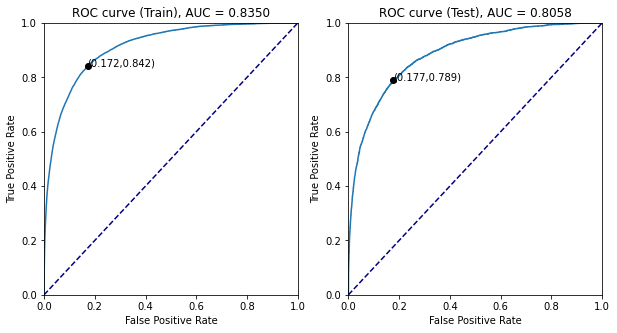

0.45935879612137503

In [ ]:
plot_ROC(y_train, base_estimator.predict_proba(X_train)[:,1], y_test, base_estimator.predict_proba(X_test)[:,1])

In [ ]:
# skip this step: trying to define some time dependency
for i in trange(len(test.columns)):
    if i == 199: break
    test[f'var_{i}_diff'] = test[f'var_{i+1}'] - test[f'var_{i}']
test.shape

  0%|          | 0/200 [00:00<?, ?it/s]

(200000, 399)

In [ ]:
# skip 
test, _, _, _ = get_count(test)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
test_preds = base_estimator.predict(test)
id_col = test.index.values
submission = pd.DataFrame(np.stack([id_col, test_preds], axis=1), columns=['ID_code', 'target'])
submission.to_csv('submission.csv', index=False, encoding='utf-8')

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f submission.csv -m 'test1'

100% 2.56M/2.56M [00:00<00:00, 5.73MB/s]
Successfully submitted to Santander Customer Transaction Prediction

In [ ]:
# catboost, keras, [features: counts, deviations, density]

In [ ]:
import scipy.ndimage

sigma_fac = 0.001
sigma_base = 4
features = X.columns.to_list()
eps = 0.00000001

def get_count(X):
    features_count = np.zeros((X.shape[0], len(features)))
    features_density = np.zeros((X.shape[0], len(features)))
    features_deviation = np.zeros((X.shape[0], len(features)))

    sigmas = []

    for i,var in enumerate(tqdm(features)):
        X_var_int = (X[var].values * 10000).round().astype(int)

        lo = X_var_int.min()
        X_var_int -= lo

        hi = X_var_int.max()+1
        counts_all = np.bincount(X_var_int, minlength=hi).astype(float)
        zeros = (counts_all == 0).astype(int)
        before_zeros = np.concatenate([zeros[1:],[0]])
        indices_all = np.arange(counts_all.shape[0])

        sigma_scaled = counts_all.shape[0]*sigma_fac
        sigma = np.power(sigma_base * sigma_base * sigma_scaled, 1/3)
        sigmas.append(sigma)
        counts_all_smooth = scipy.ndimage.filters.gaussian_filter1d(counts_all, sigma)
        deviation = counts_all / (counts_all_smooth+eps)
        indices = X_var_int
        features_count[:,i] = counts_all[indices]
        features_density[:,i] = counts_all_smooth[indices]
        features_deviation[:,i] = deviation[indices]
        
    features_count_names = [var+'_count' for var in features]
    features_density_names = [var+'_density' for var in features]
    features_deviation_names = [var+'_deviation' for var in features]
    X_count = pd.DataFrame(columns=features_count_names, data = features_count)
    X_count.index = X.index
    X_density = pd.DataFrame(columns=features_density_names, data = features_density)
    X_density.index = X.index
    X_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation)
    X_deviation.index = X.index
    X = pd.concat([X,X_count, X_density, X_deviation], axis=1)   

    features_count = features_count_names
    features_density = features_density_names
    features_deviation = features_deviation_names
    return X, features_count, features_density, features_deviation

X, features_count, features_density, features_deviation = get_count(X)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# raw
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

catboost = CatBoostClassifier(random_seed=1, verbose=False)
catboost.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=15)

cat_train_preds = catboost.predict(X_train)
cat_test_preds = catboost.predict(X_test)

report(y_train, cat_train_preds, y_test, cat_test_preds)

Train
               precision    recall  f1-score   support

           0      0.946     0.996     0.970    129530
           1      0.939     0.488     0.642     14470

    accuracy                          0.945    144000
   macro avg      0.943     0.742     0.806    144000
weighted avg      0.945     0.945     0.937    144000

Test
               precision    recall  f1-score   support

           0      0.929     0.989     0.958     35980
           1      0.767     0.322     0.453      4020

    accuracy                          0.922     40000
   macro avg      0.848     0.655     0.706     40000
weighted avg      0.913     0.922     0.907     40000

Train ROC_AUC: 0.742, Test ROC_AUC: 0.655
Confusion Matrix 
 col_0       0     1
target             
0       35587   393
1        2726  1294


In [ ]:
# raw with sampling

prepipe = Imbpipe(steps=[('selector', ColumnSelector(X_train.columns.to_list())),
                         ('under', RandomUnderSampler(sampling_strategy=0.66, random_state=1)),
                         ('over', RandomOverSampler(sampling_strategy=.8, random_state=1)),
                         ('to_df', DataFrameR(X_train.columns.to_list()))])

X_train_pipe = prepipe.fit_transform(X_train, y_train)
y_train_pipe = y_train[X_train_pipe.index]

X_valid_pipe = prepipe.transform(X_valid)
X_test_pipe = prepipe.transform(X_test)

train_pool = Pool(X_train_pipe, y_train_pipe)
valid_pool = Pool(X_valid_pipe, y_valid)

catboost = CatBoostClassifier(random_seed=1, verbose=False, auto_class_weights='Balanced')
catboost.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=15)

cat_train_preds = catboost.predict(X_train)
cat_test_preds = catboost.predict(X_test)

report(y_train, cat_train_preds, y_test, cat_test_preds)

Train
               precision    recall  f1-score   support

           0      0.901     0.546     0.680    129530
           1      0.103     0.465     0.168     14470

    accuracy                          0.538    144000
   macro avg      0.502     0.505     0.424    144000
weighted avg      0.821     0.538     0.629    144000

Test
               precision    recall  f1-score   support

           0      0.899     0.544     0.678     35980
           1      0.100     0.454     0.164      4020

    accuracy                          0.535     40000
   macro avg      0.500     0.499     0.421     40000
weighted avg      0.819     0.535     0.626     40000

Train ROC_AUC: 0.505, Test ROC_AUC: 0.499
Confusion Matrix 
 col_0       0      1
target              
0       19580  16400
1        2196   1824


In [ ]:
params_model = {
    'eval_metric': 'AUC:hints=skip_train~false',
    'auto_class_weights': 'SqrtBalanced',
    'silent': True,
    'iterations': 800,
    'early_stopping_rounds': 15,
    'boosting_type': 'Ordered', # Plain
    'grow_policy': 'SymmetricTree', # 'Depthwise', 'Lossguide'
    'allow_writing_files': False,
    'target_border': None,  # 0..1 calibration proba
    'random_seed': 1,    
}

In [ ]:
catboost = CatBoostClassifier(**params_model)

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'l2_leaf_reg': [None, 2, 2.5, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
    'colsample_bylevel': [1., 0.5, 0.3, 0.8]
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=10, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

In [ ]:
gs['params']

{'bagging_temperature': 1,
 'depth': 5,
 'l2_leaf_reg': 4,
 'learning_rate': 0.1,
 'rsm': 0.3,
 'subsample': 0.5}

In [ ]:
params_model = {
    'eval_metric': 'AUC:hints=skip_train~false',
    'auto_class_weights': 'SqrtBalanced',
    'silent': True,
    'iterations': 800,
    'early_stopping_rounds': 15,
    'boosting_type': 'Ordered', # Plain, 'Ordered'
    'grow_policy': 'SymmetricTree', # 'Depthwise', 'Lossguide', 'SymmetricTree'
    'allow_writing_files': False,
    'use_best_model': True,
    'target_border': None,  # 0..1 calibration proba, None - default
    'random_seed': 1,    
}

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

catboost = CatBoostClassifier(**params_model, 
                              bagging_temperature=1.2,
                              depth=5,
                              l2_leaf_reg=5.5,
                              learning_rate=0.06,
                              colsample_bylevel=0.3,
                              subsample=0.8,
                              #num_leaves=6,  # only for Lossguide
                              sampling_frequency='PerTreeLevel'
                              )

catboost.fit(train_pool, eval_set=valid_pool)

cat_train_preds = catboost.predict(X_train)
cat_test_preds = catboost.predict(X_test)

report(y_train, cat_train_preds, y_test, cat_test_preds)

Train
               precision    recall  f1-score   support

           0      0.952     0.968     0.960    129530
           1      0.663     0.567     0.611     14470

    accuracy                          0.928    144000
   macro avg      0.808     0.767     0.786    144000
weighted avg      0.923     0.928     0.925    144000

Test
               precision    recall  f1-score   support

           0      0.946     0.964     0.955     35980
           1      0.608     0.503     0.551      4020

    accuracy                          0.917     40000
   macro avg      0.777     0.734     0.753     40000
weighted avg      0.912     0.917     0.914     40000

Train ROC_AUC: 0.767, Test ROC_AUC: 0.734
Confusion Matrix 
 col_0       0     1
target             
0       34677  1303
1        1997  2023


In [ ]:
cat_next = CatBoostClassifier(**params_model,
                              bagging_temperature=1.2,
                              depth=5,
                              l2_leaf_reg=5.5,
                              learning_rate=0.06,
                              colsample_bylevel=0.3,
                              subsample=0.8,
                              #num_leaves=6,  # only for Lossguide
                              sampling_frequency='PerTreeLevel'
                              )
test_pool = Pool(X_test, y_test)
cat_next.fit(valid_pool, eval_set=test_pool, init_model=catboost)
cat_next_test = cat_next.predict(X_test)
print(roc_auc_score(y_test, cat_next_test))

0.740905671752411


In [ ]:
# keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32  # 256
seed = 1

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE) 
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_features = X_train.shape[1]
num_preds = 1

def get_model():
    inp = tf.keras.layers.Input((num_features*num_preds,))
    x = tf.keras.layers.Reshape((num_features*num_preds,1))(inp)
    x = tf.keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(24,1, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16,1, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(4,1, activation='elu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Reshape((num_features*4,1))(x)
    x = tf.keras.layers.AveragePooling1D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inp, outputs=out)

In [ ]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800)]             0         
                                                                 
 reshape (Reshape)           (None, 800, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 800, 32)           64        
                                                                 
 batch_normalization (BatchN  (None, 800, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 800, 24)           792       
                                                                 
 batch_normalization_1 (Batc  (None, 800, 24)          96        
 hNormalization)                                             

In [ ]:
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self):
        self.x = X_train
        self.y = y_train
        self.x_val = X_valid
        self.y_val = y_valid

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rIn a callback: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [ ]:
epochs = 100

"""
def lr_scheduler(epoch):
    if epoch <= epochs*0.8:
        return learning_rate_init
    else:
        return learning_rate_init * 0.1

learning_rate_init = 0.02
"""

metrics = [tf.keras.metrics.AUC(name='AUC'),
          ]

checkpoint_path = '.'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             #tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False),
             #tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
             ]
callbacks.append(roc_callback())

from official.nlp import optimization
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# optimizer = tf.keras.optimizers.Adam(lr=learning_rate_init, decay = 0.00001)

class_weights = create_class_weight(y_train.value_counts().to_dict())
#class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique(), y=y_train)
#class_weights = dict(enumerate(class_weights))

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

In [ ]:
history = model.fit(train_ds, 
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=callbacks,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    steps_per_epoch=steps_per_epoch
                    )

Epoch 1/100
4494/4500 [============================>.] - ETA: 0s - loss: 0.8392 - AUC: 0.5041INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.5141 - roc-auc_val: 0.5238                                                                                                    
4500/4500 [==============================] - 69s 13ms/step - loss: 0.8391 - AUC: 0.5041 - val_loss: 0.7743 - val_AUC: 0.5239
Epoch 2/100
4500/4500 [==============================] - ETA: 0s - loss: 0.6268 - AUC: 0.5278INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.5441 - roc-auc_val: 0.5515                                                                                                    
4500/4500 [==============================] - 56s 12ms/step - loss: 0.6268 - AUC: 0.5278 - val_loss: 0.5140 - val_AUC: 0.5515
Epoch 3/100
4495/4500 [============================>.] - ETA: 0s - loss: 0.4030 - AUC: 0.5646INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.5961 - roc-auc_val: 0.6005                                                                                                    
4500/4500 [==============================] - 56s 13ms/step - loss: 0.4029 - AUC: 0.5648 - val_loss: 0.3510 - val_AUC: 0.6005
Epoch 4/100
4497/4500 [============================>.] - ETA: 0s - loss: 0.3263 - AUC: 0.6307INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.6749 - roc-auc_val: 0.6749                                                                                                    
4500/4500 [==============================] - 56s 12ms/step - loss: 0.3262 - AUC: 0.6308 - val_loss: 0.3122 - val_AUC: 0.6752
Epoch 5/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.3005 - AUC: 0.7103INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.7523 - roc-auc_val: 0.7478                                                                                                    
4500/4500 [==============================] - 56s 12ms/step - loss: 0.3005 - AUC: 0.7103 - val_loss: 0.2868 - val_AUC: 0.7478
Epoch 6/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2785 - AUC: 0.7727INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.803 - roc-auc_val: 0.7955                                                                                                    
4500/4500 [==============================] - 56s 12ms/step - loss: 0.2785 - AUC: 0.7727 - val_loss: 0.2680 - val_AUC: 0.7956
Epoch 7/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2625 - AUC: 0.8097INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8315 - roc-auc_val: 0.8222                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2625 - AUC: 0.8097 - val_loss: 0.2547 - val_AUC: 0.8221
Epoch 8/100
4495/4500 [============================>.] - ETA: 0s - loss: 0.2516 - AUC: 0.8308INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8482 - roc-auc_val: 0.8378                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2515 - AUC: 0.8309 - val_loss: 0.2452 - val_AUC: 0.8379
Epoch 9/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.2438 - AUC: 0.8438INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.859 - roc-auc_val: 0.8481                                                                                                    
4500/4500 [==============================] - 56s 13ms/step - loss: 0.2437 - AUC: 0.8439 - val_loss: 0.2387 - val_AUC: 0.8480
Epoch 10/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2379 - AUC: 0.8529INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8669 - roc-auc_val: 0.8559                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2379 - AUC: 0.8529 - val_loss: 0.2437 - val_AUC: 0.8558
Epoch 11/100
4497/4500 [============================>.] - ETA: 0s - loss: 0.2334 - AUC: 0.8595INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8718 - roc-auc_val: 0.8609                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2333 - AUC: 0.8595 - val_loss: 0.2487 - val_AUC: 0.8608
Epoch 12/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2302 - AUC: 0.8640INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8754 - roc-auc_val: 0.8645                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2302 - AUC: 0.8640 - val_loss: 0.2480 - val_AUC: 0.8644
Epoch 13/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2278 - AUC: 0.8674INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8781 - roc-auc_val: 0.8672                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2278 - AUC: 0.8674 - val_loss: 0.2444 - val_AUC: 0.8672
Epoch 14/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2259 - AUC: 0.8700INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8802 - roc-auc_val: 0.8694                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2259 - AUC: 0.8701 - val_loss: 0.2410 - val_AUC: 0.8695
Epoch 15/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2243 - AUC: 0.8722INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8819 - roc-auc_val: 0.8713                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2243 - AUC: 0.8722 - val_loss: 0.2378 - val_AUC: 0.8712
Epoch 16/100
4497/4500 [============================>.] - ETA: 0s - loss: 0.2230 - AUC: 0.8740INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8834 - roc-auc_val: 0.8728                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2230 - AUC: 0.8741 - val_loss: 0.2365 - val_AUC: 0.8727
Epoch 17/100
4495/4500 [============================>.] - ETA: 0s - loss: 0.2219 - AUC: 0.8754INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8846 - roc-auc_val: 0.874                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2218 - AUC: 0.8755 - val_loss: 0.2285 - val_AUC: 0.8740
Epoch 18/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2209 - AUC: 0.8766INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8857 - roc-auc_val: 0.8751                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2209 - AUC: 0.8767 - val_loss: 0.2248 - val_AUC: 0.8750
Epoch 19/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2200 - AUC: 0.8779INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8866 - roc-auc_val: 0.8761                                                                                                    
4500/4500 [==============================] - 59s 13ms/step - loss: 0.2200 - AUC: 0.8779 - val_loss: 0.2242 - val_AUC: 0.8758
Epoch 20/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.2193 - AUC: 0.8789INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8874 - roc-auc_val: 0.8769                                                                                                    
4500/4500 [==============================] - 56s 13ms/step - loss: 0.2192 - AUC: 0.8789 - val_loss: 0.2224 - val_AUC: 0.8766
Epoch 21/100
4495/4500 [============================>.] - ETA: 0s - loss: 0.2187 - AUC: 0.8797INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8882 - roc-auc_val: 0.8776                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2186 - AUC: 0.8798 - val_loss: 0.2209 - val_AUC: 0.8775
Epoch 22/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.2180 - AUC: 0.8805INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8888 - roc-auc_val: 0.8783                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2180 - AUC: 0.8806 - val_loss: 0.2198 - val_AUC: 0.8782
Epoch 23/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2174 - AUC: 0.8813INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8894 - roc-auc_val: 0.8789                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2174 - AUC: 0.8813 - val_loss: 0.2189 - val_AUC: 0.8786
Epoch 24/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2170 - AUC: 0.8819INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.89 - roc-auc_val: 0.8794                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2169 - AUC: 0.8820 - val_loss: 0.2184 - val_AUC: 0.8791
Epoch 25/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2164 - AUC: 0.8825INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8904 - roc-auc_val: 0.8799                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2164 - AUC: 0.8825 - val_loss: 0.2181 - val_AUC: 0.8796
Epoch 26/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2160 - AUC: 0.8831INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8909 - roc-auc_val: 0.8803                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2160 - AUC: 0.8831 - val_loss: 0.2178 - val_AUC: 0.8798
Epoch 27/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.2157 - AUC: 0.8835INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8913 - roc-auc_val: 0.8807                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2156 - AUC: 0.8835 - val_loss: 0.2177 - val_AUC: 0.8804
Epoch 28/100
4497/4500 [============================>.] - ETA: 0s - loss: 0.2153 - AUC: 0.8839INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8917 - roc-auc_val: 0.8811                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2153 - AUC: 0.8839 - val_loss: 0.2176 - val_AUC: 0.8805
Epoch 29/100
4497/4500 [============================>.] - ETA: 0s - loss: 0.2150 - AUC: 0.8844INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.892 - roc-auc_val: 0.8814                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2149 - AUC: 0.8844 - val_loss: 0.2176 - val_AUC: 0.8807
Epoch 30/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.2146 - AUC: 0.8848INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8923 - roc-auc_val: 0.8817                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2146 - AUC: 0.8849 - val_loss: 0.2176 - val_AUC: 0.8810
Epoch 31/100
4497/4500 [============================>.] - ETA: 0s - loss: 0.2144 - AUC: 0.8851INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8926 - roc-auc_val: 0.8819                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2143 - AUC: 0.8852 - val_loss: 0.2177 - val_AUC: 0.8814
Epoch 32/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2141 - AUC: 0.8855INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8929 - roc-auc_val: 0.8822                                                                                                    
4500/4500 [==============================] - 56s 13ms/step - loss: 0.2140 - AUC: 0.8855 - val_loss: 0.2178 - val_AUC: 0.8816
Epoch 33/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2138 - AUC: 0.8858INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8932 - roc-auc_val: 0.8824                                                                                                    
4500/4500 [==============================] - 56s 12ms/step - loss: 0.2138 - AUC: 0.8858 - val_loss: 0.2179 - val_AUC: 0.8819
Epoch 34/100
4498/4500 [============================>.] - ETA: 0s - loss: 0.2135 - AUC: 0.8861INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8934 - roc-auc_val: 0.8826                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2135 - AUC: 0.8862 - val_loss: 0.2181 - val_AUC: 0.8823
Epoch 35/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2134 - AUC: 0.8864INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8936 - roc-auc_val: 0.8828                                                                                                    
4500/4500 [==============================] - 56s 12ms/step - loss: 0.2133 - AUC: 0.8865 - val_loss: 0.2183 - val_AUC: 0.8825
Epoch 36/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2131 - AUC: 0.8867INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8938 - roc-auc_val: 0.883                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2131 - AUC: 0.8867 - val_loss: 0.2184 - val_AUC: 0.8828
Epoch 37/100
4499/4500 [============================>.] - ETA: 0s - loss: 0.2129 - AUC: 0.8869INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.894 - roc-auc_val: 0.8832                                                                                                    
4500/4500 [==============================] - 57s 13ms/step - loss: 0.2128 - AUC: 0.8869 - val_loss: 0.2186 - val_AUC: 0.8829
Epoch 38/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2127 - AUC: 0.8870INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.8942 - roc-auc_val: 0.8833                                                                                                    
4500/4500 [==============================] - 56s 13ms/step - loss: 0.2126 - AUC: 0.8871 - val_loss: 0.2188 - val_AUC: 0.8831
Epoch 39/100
4496/4500 [============================>.] - ETA: 0s - loss: 0.2125 - AUC: 0.8872INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In a callback: 0.892 - roc-auc_val: 0.8814                                                                                                    
4500/4500 [==============================] - 58s 13ms/step - loss: 0.2125 - AUC: 0.8873 - val_loss: 0.2190 - val_AUC: 0.8831


In [ ]:
test, _, _, _ = get_count(test)
preds = model.predict(test)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
preds_labels = np.where(preds > 0.5, 1, 0)

In [ ]:
model.evaluate(test_ds)

1250/1250 [==============================] - 5s 4ms/step - loss: 0.2159 - AUC: 0.8814


[0.21589311957359314, 0.8814389705657959]

In [ ]:
test_check = model.predict(X_test)
test_check = np.where(test_check >= 0.5, 1, 0)
roc_auc_score(y_test, test_check.flatten())

0.668181673621885

In [ ]:
id_col = test.index.values
# raw predictions
submission = pd.DataFrame(np.stack([id_col, preds.ravel()], axis=1), columns=['ID_code', 'target'])
submission.to_csv('submission.csv', index=False, encoding='utf-8')

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f submission.csv -m 'test1'
# private 0.86892 public 0.86893 scores

100% 6.02M/6.02M [00:00<00:00, 12.3MB/s]
Successfully submitted to Santander Customer Transaction Prediction

Most competitors used test dataset to calculate data counts, deviations and density (as these parameters are crucial: no correlations between given variables, but new params added important statistical information that improved accuracy, as data, as occured, has frequency importance). The goal was to find out synthetic samples in test data to exclude them from generating new features. I assumed to borrow such statistic features idea, but not to use test dataset supposing it as data leakage, that is useful only for given test data and given competition. 

In [ ]:
# calculate indices of samples in test dataset, that have no unique values
df_test = pd.read_csv('test.csv')
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

100000
100000


In [ ]:
# good guide to this dataset 
# https://www.kaggle.com/felipemello/step-by-step-guide-to-the-magic-lb-0-922
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

In [ ]:
train_dist = np.array([])
test_dist = np.array([])
for col in test.columns[:200]:
    train_dist = np.append(train_dist, len(np.unique(train[col])))
    test_dist = np.append(test_dist, len(np.unique(test[col])))

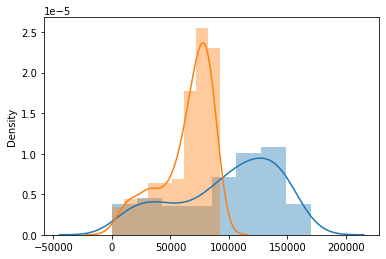

In [ ]:
sns.distplot(train_dist)
sns.distplot(test_dist)
# which somehow proves that the distributions of the number of unique values (across features) 
# is significantly different between training set and test set

In [ ]:
# KFold with separate model for each feature (200) + roc_auc weight

Train Accuracy: 0.8249652777777777 
Train AUC: 0.8110532331792722 
Train Confusion Matrix:
[[107311  22219]
 [  2986  11484]]
Test Accuracy: 0.8207 
Test AUC: 0.7994639089156773 
Test Confusion Matrix:
[[29721  6259]
 [  913  3107]]


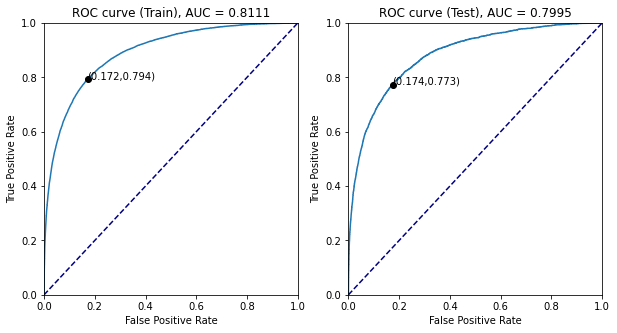

0.09732993

In [ ]:
plot_ROC(y_train, model.predict(X_train).flatten(), y_test, model.predict(X_test).flatten()) # as labels